<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:50px;padding:20px 10px;font-weight:bold">Yelp Data <p/> 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import json
from glob import glob

pd.set_option('display.max_columns', 500)
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')


# Libraries for Sentiment Analysis
import nltk
import re, string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import CountVectorizer

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:40px;padding:10px 10px;font-weight:bold">Reading in the Data <p/> 

In [2]:
# Use glob to extract our json files and save them to a list

jsons = glob('**/*.json')
jsons

['Data/yelp_academic_dataset_checkin.json',
 'Data/yelp_academic_dataset_tip.json',
 'Data/yelp_academic_dataset_review.json',
 'Data/yelp_academic_dataset_business.json',
 'Data/yelp_academic_dataset_user.json']

In [3]:
# Read in our small json files using pd.read_json

checkin = pd.read_json('Data/yelp_academic_dataset_checkin.json', lines=True)
tip = pd.read_json('Data/yelp_academic_dataset_tip.json', lines=True)
business = pd.read_json('Data/yelp_academic_dataset_business.json', lines=True)

In [34]:
# The review data is too large to read in normally, so we will read it in by chunks of 1000 at a time

# Empty list to store each chunk
chunks = [] 

# Specify dtypes 
r_dtypes = {"stars": np.float16, 
            "useful": np.int32, 
            "funny": np.int32,
            "cool": np.int32} 

# Store the json chunks
reader = pd.read_json('Data/yelp_academic_dataset_review.json',
                      lines=True,
                      chunksize=1000,
                      dtype=r_dtypes,
                      orient='records')

# For loop to append each chunk into the chunks list
for chunk in reader:
        reduced_chunk = chunk.drop(columns=['review_id', 'user_id'])\
                             .query("`date` >= '2017-12-01'")
        chunks.append(reduced_chunk)

# Concatenate each chunk into a single dataframe        
reviews = pd.concat(chunks, ignore_index=True)

In [5]:
business.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."


In [6]:
reviews.head(4)

,business_id,stars,useful,funny,cool,text,date
0,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,cPepkJeRMtHapc_b2Oe_dw,4.0,1,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07
2,kq5Ghhh14r-eCxlVmlyd8w,5.0,0,0,0,My boyfriend and I tried this deli for the fir...,2018-08-23 21:39:38
3,Zx7n8mdt8OzLRXVzolXNhQ,5.0,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21


In [7]:
print('Size of Business DataFrame: ',business.shape)
print('Size of Reviews DataFrame: ',reviews.shape)

Size of Business DataFrame:  (150346, 14)
Size of Reviews DataFrame:  (3080579, 7)


In [8]:
print('Number of Unique Businesses in Review Data: ',reviews['business_id'].nunique())
print('Number of Unique Businesses in Business Data: ',business['business_id'].nunique())

Number of Unique Businesses in Review Data:  130853
Number of Unique Businesses in Business Data:  150346


<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:40px;padding:10px 10px;font-weight:bold">Questions to Explore <p/> 

# Business
    1) Can we get a count of the unique business categories?
    2) Count for the number of each star type (5 stars, 4 stars, etc.)
    3) Count for the number of businesses that are opened vs closed, grouped by stars and/or number of reviews
    4) What are the number of businesses in each state (top 15)
    
# Reviews
    
    5) Can we perform a sentiment analysis on the text of the reviews?

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold"> Part 1: Categories <p/> 

In [9]:
business_cats=', '.join(business['categories'].dropna())
cats=pd.DataFrame(business_cats.split(', '),columns=['category'])
cats_ser = cats.category.value_counts()
cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)

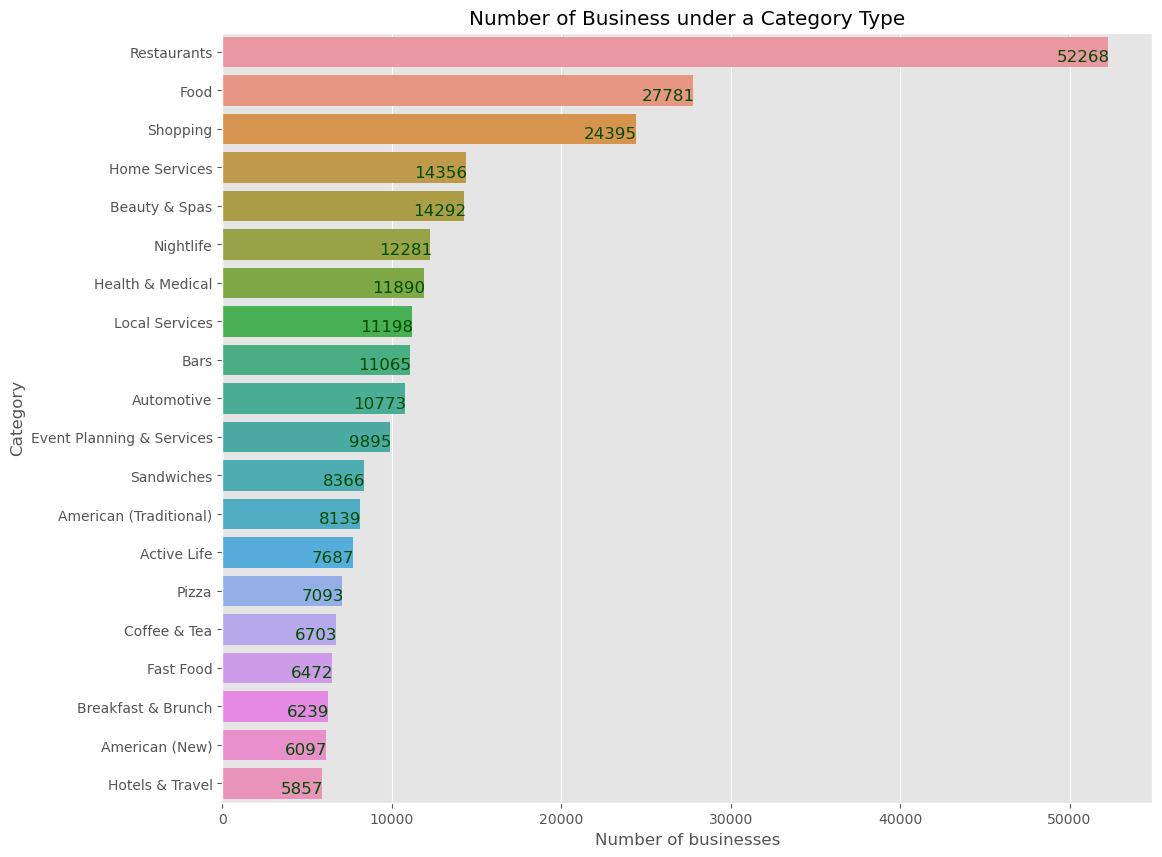

In [10]:
plt.figure(figsize=(12,10))
ax = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
ax.set_ylabel('Category')
ax.set_xlabel('Number of businesses')
ax.set_title('Number of Business under a Category Type')



for p in ax.patches:
    ax.annotate(int(p.get_width()),
                ((p.get_x() + p.get_width()),
                 p.get_y()),
                 xytext=(1, -18),
                fontsize=12,
                color='#004d00',
                textcoords='offset points',
                horizontalalignment='right')   
plt.show()    

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Part 2: Stars <p/> 

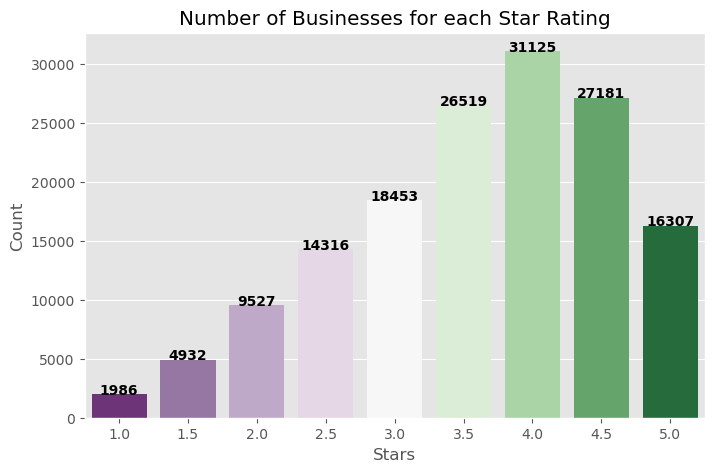

In [11]:
plt.figure(figsize=(8,5))
ax = sns.countplot( x='stars' , data = business, palette='PRGn')
ax.set_ylabel('Count')
ax.set_xlabel('Stars')
ax.set_title('Number of Businesses for each Star Rating')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.4, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center') 
                
plt.show()

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Part 3: Open vs Closed Businessnes <p/> 

In [12]:
business['is_open'].value_counts()

1    119698
0     30648
Name: is_open, dtype: int64

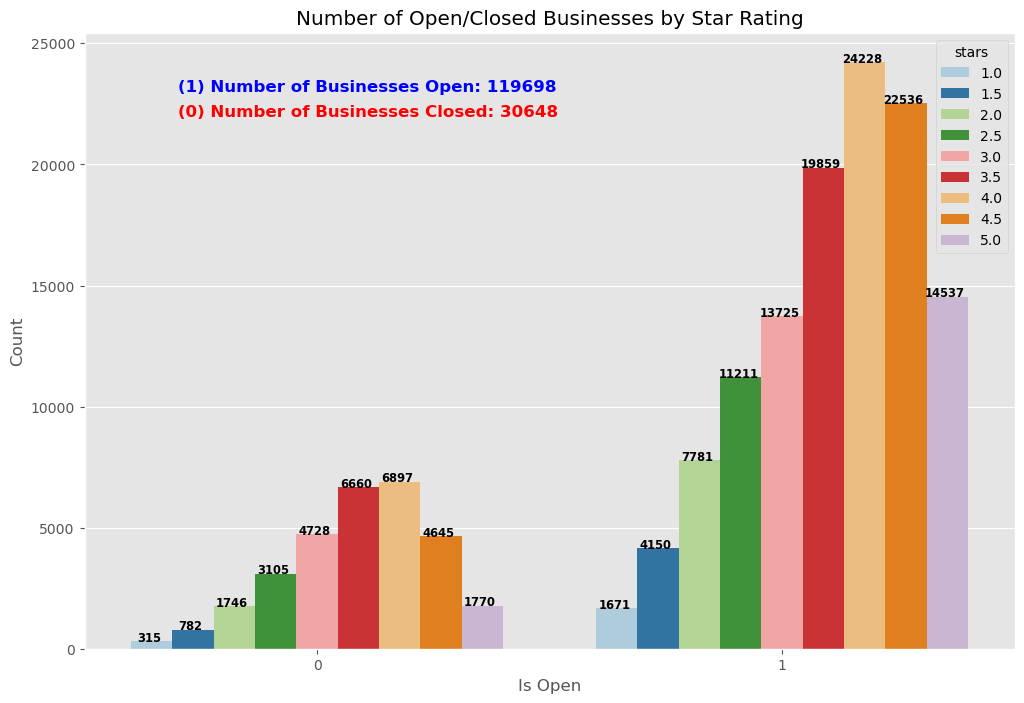

In [14]:
plt.figure(figsize=(12,8))
ax = sns.countplot(hue='stars', x='is_open'  , data = business, palette='Paired')
ax.set_ylabel('Count')
ax.set_xlabel('Is Open')
ax.set_title('Number of Open/Closed Businesses by Star Rating')


num_open , num_closed = business['is_open'].value_counts()

ax.text(-0.3, 23000,
        '(1) Number of Businesses Open: {:.0f}'.format(num_open),
        weight='bold',
        color='blue',
        size='large')

ax.text(-0.3, 22000,
        '(0) Number of Businesses Closed: {:.0f}'.format(num_closed),
        weight='bold',
        color='red',
        size='large')



for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.05, 
                y+height,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
                size='small') 
                
plt.show()

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Part 4: State <p/> 

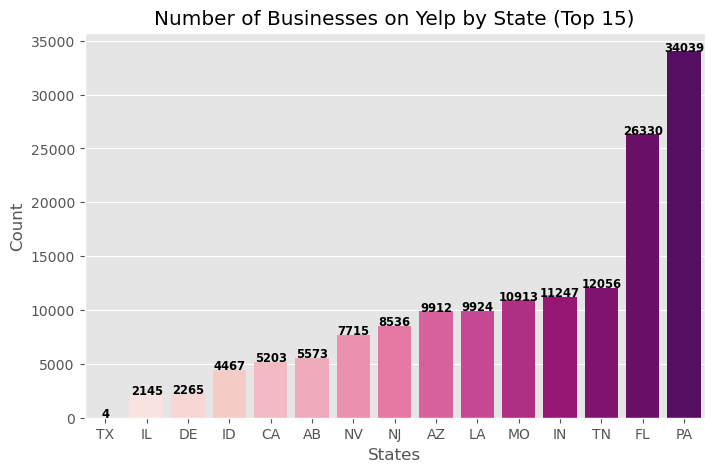

In [15]:
top15 = business['state'].value_counts(ascending=True).tail(15).to_frame()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=top15.index,y='state', data=top15, palette='RdPu')
ax.set_ylabel('Count')
ax.set_xlabel('States')
ax.set_title('Number of Businesses on Yelp by State (Top 15)')

for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width-.4, 
                y+height+2,
                '{:.0f}'.format(height),
                weight='bold',
                horizontalalignment='center',
               size='small') 
                
plt.show()

<p style="background-color:rgb(106,90,205);color:rgb(255,255,255);text-align:center;font-size:30px;padding:10px 10px;font-weight:bold">Part 5: Sentiment Analysis <p/> 

In [39]:
# Recode 1,2, and 3 stars as 0 (negative review)
# Recode 4 and 5 stars as 1 (positive review)

reviews['sentiment']=reviews['stars'].replace({1:0,2:0,3:0,4:1,5:1})
reviews['sentiment'] = reviews['sentiment'].astype(int)

In [127]:
# Since this dataset is so large, we will work with a random sample of 100,000 reviews

reviews_subset = reviews.sample(100000).reset_index(drop=True)

In [128]:
# Subset of the columns of interest

df = reviews_subset[['text','sentiment']]
df.head()

,text,sentiment
0,Me and my son had cuts \nAfter careful review ...,0
1,The best customer service and nails designs in...,1
2,Great authentic Vietnamese food. Has a big men...,1
3,Matt was FANTASTIC! The food was delicious an...,1
4,This place is fantastic. My daughter is disabl...,1


In [129]:
# Convert strings to lowercase

df['pre_process'] = df['text'].apply(lambda x:' '.join(x.lower() for x in str(x).split()))


# Convert contractions into separate words (won't = will not)

def contractions(s):
     s = re.sub(r"won’t", "will not",s)
     s = re.sub(r"would’t", "would not",s)
     s = re.sub(r"could’t", "could not",s)
     s = re.sub(r"\’d",  " would",s)
     s = re.sub(r"can\’t", "can not",s)
     s = re.sub(r"n\’t", " not", s)
     s= re.sub(r"\’re", " are", s)
     s = re.sub(r"\’s", " is", s)
     s = re.sub(r"\’ll", " will", s)
     s = re.sub(r"\’t", " not", s)
     s = re.sub(r"\’ve", " have", s)
     s = re.sub(r"\’m", " am", s)
     return s
df['pre_process']=df['pre_process'].apply(lambda x:contractions(x))


# Remove non-alpha characters

df['pre_process']=df['pre_process'].apply(lambda x: ' '.join([re.sub('[^A-Za-z]+','', x) for x in nltk.word_tokenize(x)]))


# Remove extra spaces between words

df['pre_process']=df['pre_process'].apply(lambda x: re.sub(' +', ' ', x))


# Remove stop words

stop = stopwords.words("english")
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([x for x in x.split() if x not in stop]))


# Lemmatization

lemmatizer = WordNetLemmatizer()
df['pre_process']=df['pre_process'].apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in nltk.word_tokenize(x)]))

In [143]:
X = df['pre_process']
y = df['sentiment']

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train: ",X_train.shape,y_train.shape,"Test: ",(X_test.shape,y_test.shape))

Train:  (80000,) (80000,) Test:  ((20000,), (20000,))


In [162]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer()
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)

In [163]:
from sklearn.svm import LinearSVC

clf = LinearSVC(random_state=0)

clf.fit(tf_x_train,y_train)

y_test_pred=clf.predict(tf_x_test)

from sklearn.metrics import classification_report
report=classification_report(y_test, y_test_pred,output_dict=True)

In [164]:
pd.DataFrame(report)

,0,1,accuracy,macro avg,weighted avg
precision,0.893550,0.936453,0.92275,0.915002,0.922353
recall,0.868401,0.949356,0.92275,0.908878,0.922750
f1-score,0.880796,0.942860,0.92275,0.911828,0.922463
support,6573.000000,13427.000000,0.92275,20000.000000,20000.000000


# Testing out the model:

## Positive Review from the data

In [174]:
reviews_subset['text'][43]

'Amazing tour around Philly! The host is HILARIOUS and v hospitable and compassionate - he is also v knowledgeable about random facts about Philly. Only tour guide you can do BYOB too! Lots of fun + lots of laughs. 100% recommend, you will love it.'

In [175]:
df['pre_process'][43]

'amazing tour around philly host hilarious v hospitable compassionate also v knowledgeable random fact philly tour guide byob lot fun lot laugh recommend love'

In [176]:
positive_review = df['pre_process'][43]
positive_review = [positive_review]

pos_review_transformed = vectorizer.transform(positive_review)

pos_review_pred = clf.predict(pos_review_transformed)

print(pos_review_pred)

[1]


## Negative Review from the data

In [171]:
reviews_subset['text'][65]

"Grabbed some stir fry noodles to go last night and was pretty disappointed. It's been almost a year since I had Honeygrow so I was looking forward to my dinner, but when I opened the take out box, and poured it out, a good chunk of the middle was not stir fried. It was just plain egg noodles with no seasoning. When and why did you go back to packaging them in boxes, the take out bowls were way better and prevented the noodles from conforming to the shape of the take out box. What's up with the mushrooms too? They were sliced paper thin. I was so turned off by my dinner and don't think I will ever come back, at least not to this Honeygrow."

In [169]:
df['pre_process'][65]

'grabbed stir fry noodle go last night pretty disappointed almost year since honeygrow looking forward dinner opened take box poured good chunk middle stir fried plain egg noodle seasoning go back packaging box take bowl way better prevented noodle conforming shape take box mushroom sliced paper thin turned dinner nt think ever come back least honeygrow'

In [177]:
negative_review = df['pre_process'][65]
negative_review = [negative_review]

neg_review_transformed = vectorizer.transform(negative_review)

neg_review_pred = clf.predict(neg_review_transformed)

print(neg_review_pred)

[0]


## Custom Reviews

In [185]:
cus_pos_review = 'Blown away by almost every dish. The freshness of the herbs and vegetables, the tenderness of the duck and steak, the complex spices and of the shan tofu and salads! Not your typical southeast Asian restaurant. Definitely a little bit of a twist, but it works well. We tried all the main entrees and a few appetizers, but the standouts were the shan tofu, ribeye done medium rare (you must dip it in the sauce), crispy trout, and beef stir fry. Salads are bright and refreshing. The lighting and decor is sleek and beautiful, service kind and helpful. A bit of a splurge depending on how you order, but what an experience!'
cus_neg_review = "I have dined in a multitude of culinary institutes and Michelin star restaurants not only in the US but abroad as well. I was never treated the way I was treated here with the 2 disgusting hostesses on the night of June 17 2022. Who also decided to harass us and say 'well are you guys going to order anything?!' as we were waiting for our food patiently for 1 AND A HALF HOURS. I did not a receive an apology for her attitude or assumptions nor an apology for the constant glares I was receiving. Very classless and disgusting. Despite the food being good, I will never come back nor recommend this place to friends. I felt very uncomfortable, harassed and UNWANTED like I did not belong there. I did not want to eat anymore. Please re evaluate your hostesses as they're ruining the authentic cultural experience that the owners are trying to portray."
cus_neu_review = "Great cocktails great vibe, beautiful patio. Very average food for a price. Ok service not super attending. Not family friendly or at least our server wasn't accommodating our son in a best way. We won't be back, but check out on your own"

In [182]:
cus_pos_review

'Blown away by almost every dish. The freshness of the herbs and vegetables, the tenderness of the duck and steak, the complex spices and of the shan tofu and salads! Not your typical southeast Asian restaurant. Definitely a little bit of a twist, but it works well. We tried all the main entrees and a few appetizers, but the standouts were the shan tofu, ribeye done medium rare (you must dip it in the sauce), crispy trout, and beef stir fry. Salads are bright and refreshing. The lighting and decor is sleek and beautiful, service kind and helpful. A bit of a splurge depending on how you order, but what an experience!'

In [183]:
cus_pos_review = [cus_pos_review]

cus_pos_review_transformed = vectorizer.transform(cus_pos_review)

cus_pos_review_pred = clf.predict(cus_pos_review_transformed)

print(cus_pos_review_pred)

[1]


In [181]:
cus_neg_review

"I have dined in a multitude of culinary institutes and Michelin star restaurants not only in the US but abroad as well. I was never treated the way I was treated here with the 2 disgusting hostesses on the night of June 17 2022. Who also decided to harass us and say 'well are you guys going to order anything?!' as we were waiting for our food patiently for 1 AND A HALF HOURS. I did not a receive an apology for her attitude or assumptions nor an apology for the constant glares I was receiving. Very classless and disgusting. Despite the food being good, I will never come back nor recommend this place to friends. I felt very uncomfortable, harassed and UNWANTED like I did not belong there. I did not want to eat anymore. Please re evaluate your hostesses as they're ruining the authentic cultural experience that the owners are trying to portray."

In [184]:
cus_neg_review = [cus_neg_review]

cus_neg_review_transformed = vectorizer.transform(cus_neg_review)

cus_neg_review_pred = clf.predict(cus_neg_review_transformed)

print(cus_neg_review_pred)

[0]


In [186]:
cus_neu_review

"Great cocktails great vibe, beautiful patio. Very average food for a price. Ok service not super attending. Not family friendly or at least our server wasn't accommodating our son in a best way. We won't be back, but check out on your own"

In [187]:
cus_neu_review = [cus_neu_review]

cus_neu_review_transformed = vectorizer.transform(cus_neu_review)

cus_neu_review_pred = clf.predict(cus_neu_review_transformed)

print(cus_neu_review_pred)

[1]


# Results:

## - Our model has a prediction accuracy of 92%
## - The model is slightly better at predicting postive reviews (93%) as opposed to negative reivews (89%)
## - The model was able to accurately predict the sentiment for 2 random reviews chosen from the data (1 positive and 1 negative)
## - The model was able to accurately predict the sentiment for 2 custom reviews
## - Note:  When a  neutral review was put through the model it predicts it as positive. It is to be expected that the model will get confused with neutral (3 star) reviews. It may be more appropriate  to change this to multi-class classification where we regroup the star ratings to have positive, negative, AND neutral.